In [62]:
import pandas as pd
import os
import seaborn as sb
import datetime
import numpy as np

# Load Data

In [10]:
client_df = pd.read_csv('.\\ficheiros_competicao_dev\\client.csv', sep=';', low_memory=False)

account_df = pd.read_csv('.\\ficheiros_competicao_dev\\account.csv', sep=';', low_memory=False)

trans_dev_df = pd.read_csv('.\\ficheiros_competicao_dev\\trans_dev.csv', sep=';', low_memory=False)

loan_dev_df = pd.read_csv('.\\ficheiros_competicao_dev\\loan_dev.csv', sep=';', low_memory=False)

card_dev_df = pd.read_csv('.\\ficheiros_competicao_dev\\card_dev.csv', sep=';', low_memory=False)

disp_df = pd.read_csv('.\\ficheiros_competicao_dev\\disp.csv', sep=';', low_memory=False)

district_df = pd.read_csv('.\\ficheiros_competicao_dev\\district.csv', sep=';', low_memory=False)

# Domain Analysis

## Business Understanding

### End User Requirements

The end user requires a system to determine which clients are and are not capable of paying of the loans they seek to make of the end user.

### Business Goals

In this problem the positive case is a client that cannot pay a loan. The business goal is to create a system to:
- Reduce the amount of loan attributions to clients who will default on the loan
- Mantain the amount of loan attributions to clients who can fulfill the loan

### Data Mining Goals

From the business goals we can determine that the goal of the model is to avoid granting a loan to a client who cannot pay it back, minimize false negatives so we must optimze for recall.

## Data Understanding

### Loans

In [11]:
len(loan_dev_df[loan_dev_df['status'] == 1]) / len(loan_dev_df) * 100

85.97560975609755

Around 86% of loans in the dataset have been payed off, so accuracy is not the best measure to optimize for.

<AxesSubplot:xlabel='status', ylabel='amount'>

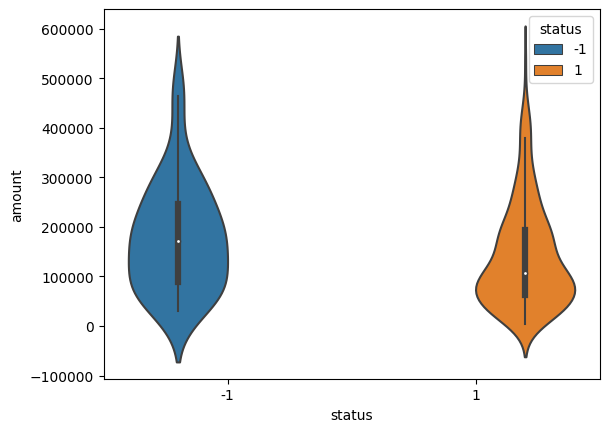

In [12]:
sb.violinplot(x='status', y='amount', data=loan_dev_df, hue='status')

We can see a larger amount of the loans over 100,000 are not payed off.

# Data Treatment

## Missing Values

### Acount

In [13]:
account_df.isnull().sum()

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

No missing values on **account_df**

### Client

In [14]:
client_df.isnull().sum()

client_id       0
birth_number    0
district_id     0
dtype: int64

No missing values on **client_df**

### Loans

In [15]:
loan_dev_df.isnull().sum()

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

No missing values on **loan_dev_df**

### Transactions

In [16]:
trans_dev_df.isnull().sum()

trans_id           0
account_id         0
date               0
type               0
operation      70761
amount             0
balance            0
k_symbol      185244
bank          299443
account       294456
dtype: int64

There are missing values on **trans_dev_df**

#### Operation

In [17]:
trans_dev_df['operation'].value_counts()

withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

In [18]:
len(trans_dev_df[trans_dev_df['operation'].isnull()]) / len(trans_dev_df['operation']) * 100

17.838083113805663

There is a significant number of null values in the operations column. These will be replaced by 'N/A'.

In [19]:
trans_dev_df['operation'].fillna('N/A', inplace=True)

In [20]:
trans_dev_df['operation'].value_counts()

withdrawal in cash              165270
N/A                              70761
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

#### K Symbol

In [21]:
trans_dev_df['k_symbol'].value_counts()

interest credited                        70761
payment for statement                    58377
household                                42839
                                         19065
old-age pension                          13502
insurrance payment                        6592
sanction interest if negative balance      305
Name: k_symbol, dtype: int64

There are many empty string values. It is assumed these mean the transaction type wasn't registered and they will be treated the same as null values.

In [22]:
def remove_empty_values_k_symbol(k):
    if isinstance(k, float):
        return'N/A'
    elif isinstance(k, str) and k.strip() == '':
        return 'N/A'
    else:
        return k

trans_dev_df['k_symbol'] = trans_dev_df['k_symbol'].apply(remove_empty_values_k_symbol)

trans_dev_df['k_symbol'].value_counts()

N/A                                      204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64

#### Bank

In [23]:
trans_dev_df['bank'].value_counts()

ST    8114
GH    7886
EF    7878
AB    7666
UV    7618
OP    7595
IJ    7536
YZ    7471
QR    7413
KL    7397
WX    7033
CD    7009
MN    6626
Name: bank, dtype: int64

There aren't any empty strings. Null values will be replaced by unknown.

In [24]:
trans_dev_df['bank'].fillna('Unknown', inplace=True)

In [25]:
trans_dev_df['bank'].value_counts()

Unknown    299443
ST           8114
GH           7886
EF           7878
AB           7666
UV           7618
OP           7595
IJ           7536
YZ           7471
QR           7413
KL           7397
WX           7033
CD           7009
MN           6626
Name: bank, dtype: int64

#### Account

In [26]:
trans_dev_df['account'].value_counts()

0.0           4987
15916598.0      48
62457513.0      48
6149286.0       48
42988401.0      48
              ... 
99218499.0       1
54261672.0       1
28306174.0       1
91523855.0       1
53761804.0       1
Name: account, Length: 4536, dtype: int64

There are many transactions to an account **0**. This will be treated as a transaction to an unknown account.

In [27]:
trans_dev_df['account'].fillna(0, inplace=True)

In [28]:
trans_dev_df['account'].value_counts()

0.0           299443
30300313.0        48
37906074.0        48
45134812.0        48
15916598.0        48
               ...  
99218499.0         1
54261672.0         1
28306174.0         1
91523855.0         1
53761804.0         1
Name: account, Length: 4536, dtype: int64

### Cards

In [29]:
card_dev_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

There are no missing values in **card_dev_df**

### Disposition

In [30]:
disp_df.isnull().sum()

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

There are no missing values in **disp_df**

### District

In [31]:
district_df.isnull().sum()

code                                                 0
name                                                 0
region                                               0
no. of inhabitants                                   0
no. of municipalities with inhabitants < 499         0
no. of municipalities with inhabitants 500-1999      0
no. of municipalities with inhabitants 2000-9999     0
no. of municipalities with inhabitants >10000        0
no. of cities                                        0
ratio of urban inhabitants                           0
average salary                                       0
unemploymant rate '95                                0
unemploymant rate '96                                0
no. of enterpreneurs per 1000 inhabitants            0
no. of commited crimes '95                           0
no. of commited crimes '96                           0
dtype: int64

There are no missing values in **district_df**

## Date Functions

In [32]:
# Format birth number to date (DD-MM-YY) <- may need to change formatting for algorithms
def get_formatted_date(date_number):
    date_number_string = str(date_number)
    return date_number_string[4:6] + '/' + str(int(date_number_string[2:4]) % 50) + '/' + '19' + date_number_string[0:2]

# Get client sex from birth number (MM > 50 => sex == 'F')
def get_client_sex_from_birth_number(date_number):
    return 'F' if int(str(date_number)[2:4]) >= 51 else 'M'


## Format dates and determine client sex

In [33]:
# Format client birthday and determine sex

client_df['birthday'] = pd.to_datetime(client_df['birth_number'].apply(get_formatted_date), infer_datetime_format=True)

client_df['sex'] = client_df['birth_number'].apply(get_client_sex_from_birth_number)

client_df = client_df.drop(columns=['birth_number'])

# Format other dates

account_df['acc_creation_date'] = pd.to_datetime(account_df['date'].apply(get_formatted_date), infer_datetime_format=True)

account_df = account_df.drop(columns=['date'])

trans_dev_df['trans_date'] = pd.to_datetime(trans_dev_df['date'].apply(get_formatted_date), infer_datetime_format=True)

trans_dev_df = trans_dev_df.drop(columns=['date'])

loan_dev_df['date'] = pd.to_datetime(loan_dev_df['date'].apply(get_formatted_date), infer_datetime_format=True)

card_dev_df['issued'] = pd.to_datetime(card_dev_df['issued'].apply(get_formatted_date), infer_datetime_format=True)

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '14/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packag

## Whitespace Removal

In [48]:
district_df.rename(columns=lambda x: x.strip(), inplace=True)

# Join Data

Data must all be displayed in one dataset.

## Join Account and Disposition

In [82]:
joined_df = account_df.merge(disp_df, on='account_id', how='inner', suffixes=['', '_disp'])

joined_df.rename(columns={
    'type': 'account_type',
    'frequency': 'issuance_freq'
}, inplace=True)

# Determine if account is shared or not
owner_number_account = joined_df['account_id'].value_counts()

joined_df['shared'] = joined_df.apply(lambda row: 1 if owner_number_account[row['account_id']] > 1 else 0, axis=1)

# Drop rows with disponents so there are no duplicated account rows
joined_df.drop(joined_df[joined_df['account_type'] == 'DISPONENT'].index, inplace=True)

# Drop account_type and disp_id column
joined_df.drop(columns=['account_type'], inplace=True)

joined_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,client_id,shared
0,576,55,monthly issuance,1993-01-01,692,692,1
2,3818,74,monthly issuance,1993-01-01,4601,4601,1
4,704,55,monthly issuance,1993-01-01,844,844,1
6,2378,16,monthly issuance,1993-01-01,2873,2873,0
7,2632,24,monthly issuance,1993-02-01,3177,3177,0


## Join Clients

In [83]:
joined_df = joined_df.merge(client_df, on='client_id', how='left', suffixes=['', '_client'])

joined_df.drop(columns=['client_id'], inplace=True)

joined_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,shared,district_id_client,birthday,sex
0,576,55,monthly issuance,1993-01-01,692,1,74,1936-01-11,F
1,3818,74,monthly issuance,1993-01-01,4601,1,1,1935-04-02,M
2,704,55,monthly issuance,1993-01-01,844,1,22,1945-01-14,M
3,2378,16,monthly issuance,1993-01-01,2873,0,16,1975-03-24,F
4,2632,24,monthly issuance,1993-02-01,3177,0,24,1938-08-12,M


## Join District

There are currently two District ids in the dataset for each row. We are going to join on the client's district id since we surmise this information will be more relevant to wheter they pay off the loan or not than the district the account was regitered on.

In [84]:
joined_df = joined_df.merge(district_df, left_on='district_id_client', right_on='code', how='inner', suffixes=['', '_district'])

joined_df.rename(columns={
    'code': 'district_code',
    'name': 'disctrict_name'
}, inplace=True)

joined_df.drop(columns=['district_id', 'district_id_client'], inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,disctrict_name,region,...,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,576,monthly issuance,1993-01-01,692,1,1936-01-11,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
1,2484,monthly issuance,1993-03-01,2999,0,1979-03-24,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
2,1338,monthly issuance,1993-11-01,1619,1,1942-01-27,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
3,1179,monthly issuance,1993-01-23,1419,1,1918-01-25,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782,18347
4,1649,monthly issuance,1993-01-26,1999,0,1982-02-10,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782,18347


## Join Loan

In [85]:
joined_df = joined_df.merge(loan_dev_df, on='account_id', how='right', suffixes=['', '_loan'])

joined_df.drop(columns=['loan_id'], inplace=True)

joined_df.rename(columns={
    'date': 'loan_date'
}, inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,disctrict_name,region,...,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,loan_date,amount,duration,payments,status
0,1787,weekly issuance,1993-03-22,2166,0,1947-07-22,F,30,Sokolov,west Bohemia,...,3.38,3.67,100,2985,2804,1993-05-07,96396,12,8033,-1
1,1801,monthly issuance,1993-02-13,2181,0,1968-07-22,M,46,Nachod,east Bohemia,...,1.79,2.31,117,2854,2618,1993-11-07,165960,36,4610,1
2,9188,monthly issuance,1993-08-02,11006,0,1936-06-02,M,45,Jicin,east Bohemia,...,2.28,2.89,132,2080,2122,1993-07-28,127080,60,2118,1
3,1843,monthly issuance,1993-01-30,2235,0,1940-04-20,F,14,Ceske Budejovice,south Bohemia,...,1.42,1.71,135,6604,6295,1993-03-08,105804,36,2939,1
4,11013,weekly issuance,1993-02-14,13231,0,1978-09-07,M,63,Vyskov,south Moravia,...,3.79,4.52,110,1562,1460,1993-06-09,274740,60,4579,1


## Determine account owner age on loan request

In [86]:
joined_df['age_on_loan_request'] = joined_df.apply(lambda row: (row['loan_date'] - row['birthday'])/np.timedelta64(1, 'Y'), axis=1)

joined_df.drop(columns=['birthday'], inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,disctrict_name,region,no. of inhabitants,...,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,loan_date,amount,duration,payments,status,age_on_loan_request
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,3.67,100,2985,2804,1993-05-07,96396,12,8033,-1,45.794233
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,2.31,117,2854,2618,1993-11-07,165960,36,4610,1,25.295523
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,2.89,132,2080,2122,1993-07-28,127080,60,2118,1,57.153809
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,1.71,135,6604,6295,1993-03-08,105804,36,2939,1,52.882674
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,4.52,110,1562,1460,1993-06-09,274740,60,4579,1,14.754581


## Join Cards

There are a lot of clients without cards so simply joining the datasets would result in a large amount of null values. Instead we will record the card score attached to each account giving more weight to *classic* and *gold* cards. This is done beacause to have access to better credit cards the client must have a history of making and paying of loans in time.(Weights may change)

In [87]:
card_disp_df = card_dev_df.merge(disp_df, on='disp_id', how='inner', suffixes=['_card', '_disp'])

cards_per_user_df = card_disp_df.groupby(['account_id', 'type_card']).size().unstack(fill_value=0)

joined_df = joined_df.merge(cards_per_user_df, on='account_id', how='left', suffixes=['', ''])

joined_df.fillna(0, inplace=True)

joined_df['card_score'] = (joined_df['junior'] + joined_df['classic'] * 3 + joined_df['gold'] * 10).astype(int)

joined_df.drop(columns=['junior', 'classic', 'gold'], inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,disctrict_name,region,no. of inhabitants,...,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,loan_date,amount,duration,payments,status,age_on_loan_request,card_score
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,100,2985,2804,1993-05-07,96396,12,8033,-1,45.794233,0
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,117,2854,2618,1993-11-07,165960,36,4610,1,25.295523,0
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,132,2080,2122,1993-07-28,127080,60,2118,1,57.153809,0
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,135,6604,6295,1993-03-08,105804,36,2939,1,52.882674,0
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,110,1562,1460,1993-06-09,274740,60,4579,1,14.754581,0
